In [2]:
import wandb
import os

api_key = "ed96694f53a6d97d5550ad5db5a5cdee06b0257b"

wandb.login(key=api_key)

project_name = "glm"
entity_name = "whaterveranyway"

wandb.init(project=project_name, entity=entity_name)

log_dir = "/gpfs/gibbs/pi/gerstein/xt86/by/hyena-dna/outputs/2024-07-17/11-57-01-495655/wandb/latest-run"

assert os.path.exists(log_dir), "日志文件夹不存在"

log_files = [f for f in os.listdir(log_dir) if os.path.isfile(os.path.join(log_dir, f))]

for log_file in log_files:
    wandb.save(os.path.join(log_dir, log_file))

wandb.finish()


wandb: Currently logged in as: whaterveranyway (zjucv). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/xt86/.netrc


In [1]:
import time
import sys
sys.path.append("/mnt/nas/share2/home/by/hyena-dna")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from src.models.sequence.denoise import CNNModel
from src.models.sequence.caduceus import Caduceus
from src.models.sequence.caduceus import  Hyena
from omegaconf import DictConfig
import torch
import math


/home/by/miniconda3/envs/hyena-dna/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/nas/share2/home/by/hyena-dna/src/models/sequence/convNext.py:264: UserWarning: Overwriting convnext_tiny in registry with src.models.sequence.convNext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False,in_22k=False, **kwargs):
/mnt/nas/share2/home/by/hyena-dna/src/models/sequence/convNext.py:273: UserWarning: Overwriting convnext_small in registry with src.models.sequence.convNext.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_small(pretrained=False,in_22k=False, **kwargs):
/mnt/nas/share2/home/by/hyena-dna/src

In [3]:
args = DictConfig({
    "clean_data": False,
    "hidden_dim": 512,
    "cls_expanded_simplex": True,
    "mode": "dirichlet",
    "num_cnn_stacks": 1,
    "dropout": 0.0,
    "cls_free_guidance": False,
    "alpha_max": 8,
    "fix_alpha": 1e6,
    "alpha_scale": 2,
    "prior_pseudocount": 2,
    "seed": 2222,
})
dcgcnn = CNNModel(args, 5, 0,classifier=False, for_representation=True, pretrain=False, dilation=4, kernel_size=9, mlp=True, out_dim=2, length=248, use_outlinear=False, forget=True, num_conv1d=5, d_inner=2, final_conv=True, use_comp=True).to("cuda")

In [41]:
caduceus = Caduceus(mode="ph", size=7.7, out_dim=2).to("cuda")

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Some weights of CaduceusForMaskedLM were not initialized from the model checkpoint at kuleshov-group/caduceus-ph_seqlen-131k_d_model-256_n_layer-16 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
hyena = Hyena(4500, 2).to("cuda")

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Some weights of the model checkpoint at LongSafari/hyenadna-large-1m-seqlen-hf were not used when initializing HyenaDNAForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing HyenaDNAForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HyenaDNAForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Hy

In [4]:
B = 1
L = 10000

In [7]:
import time
import torch
from torch.utils.data import DataLoader

# 定义模型

total_time = 0
itrs = 100
dcgcnn.eval()
for i in range(itrs):
    input_data = torch.randint(0, 4, (B, L)).cuda()  # 创建一个形状为[B, L]的序列，序列中都是int，从0-3

    # 确保所有初始化的CUDA操作都已完成
    torch.cuda.synchronize()

    # 开始计时
    start = time.time()

    # 运行模型
    output = dcgcnn(input_data)

    # 确保所有CUDA操作都已完成
    torch.cuda.synchronize()

    # 结束计时
    end = time.time()
    total_time += end-start

# 打印运行时间
print('dcgcnn Inference time:', math.log(total_time/itrs*1000))
del dcgcnn, input_data

dcgcnn Inference time: 2.250088742879009


In [8]:
import time
import torch
from torch.utils.data import DataLoader

# 定义模型

total_time = 0
itrs = 100
caduceus.eval()
for i in range(itrs):
    input_data = torch.randint(0, 4, (B, L)).cuda()  # 创建一个形状为[B, L]的序列，序列中都是int，从0-3

    # 确保所有初始化的CUDA操作都已完成
    torch.cuda.synchronize()

    # 开始计时
    start = time.time()

    # 运行模型
    output = caduceus(input_data)

    # 确保所有CUDA操作都已完成
    torch.cuda.synchronize()

    # 结束计时
    end = time.time()
    total_time += end-start

# 打印运行时间
print('caduceus Inference time:', math.log(total_time/itrs*1000))
del caduceus, input_data

/mnt/nas/share2/home/by/hyena-dna/src/models/sequence/caduceus.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_tensor = torch.tensor(input_ids)


caduceus Inference time: 4.876486111191305


In [9]:
import time
import torch
from torch.utils.data import DataLoader

# 定义模型

# 创建一个模拟的输入数据
B = 32  # 批量大小
L = 1000  # 序列长度
total_time = 0
itrs = 100
hyena.eval()
for i in range(itrs):
    input_data = torch.randint(0, 4, (B, L)).cuda()  # 创建一个形状为[B, L]的序列，序列中都是int，从0-3

    # 确保所有初始化的CUDA操作都已完成
    torch.cuda.synchronize()

    # 开始计时
    start = time.time()

    # 运行模型
    output = hyena(input_data)

    # 确保所有CUDA操作都已完成
    torch.cuda.synchronize()

    # 结束计时
    end = time.time()
    total_time += end-start

# 打印运行时间
print('hyena Inference time:', math.log(total_time/itrs*1000))
del hyena, input_data

hyena Inference time: 1.335824827441141


In [17]:
from thop import profile
import torch

input_data = torch.randint(0, 4, (B, L)).cuda()
# 使用profile函数计算FLOPs
macs, params = profile(dcgcnn, inputs=(input_data, ))

print('FLOPs: ', macs)
print('Params: ', params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
FLOPs:  55107584000.0
Params:  1721472.0


In [20]:
from thop import profile
import torch

input_data = torch.randint(0, 4, (B, L)).cuda()
# 使用profile函数计算FLOPs
macs, params = profile(caduceus, inputs=(input_data, ))

print('FLOPs: ', macs)
print('Params: ', params)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
FLOPs:  16384.0
Params:  512.0


/mnt/nas/share2/home/by/hyena-dna/src/models/sequence/caduceus.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_tensor = torch.tensor(input_ids)


In [9]:
from thop import profile
import torch

input_data = torch.randint(0, 4, (B, L)).cuda()
# 使用profile函数计算FLOPs
macs, params = profile(hyena, inputs=(input_data, ))

print('FLOPs: ', macs)
print('Params: ', params)

[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
FLOPs:  65269796864.0
Params:  6544384.0


In [4]:
# nelement()：统计Tensor的元素个数
#.parameters()：生成器，迭代的返回模型所有可学习的参数，生成Tensor类型的数据
total = sum([param.nelement() for param in dcgcnn.parameters()])
print("dcgcnn Number of parameter: %.2fM" % (total/1e6))
total = sum([param.nelement() for param in caduceus.parameters()])
print("caduceus Number of parameter: %.2fM" % (total/1e6))
total = sum([param.nelement() for param in hyena.parameters()])
print("hyena Number of parameter: %.2fM" % (total/1e6))

dcgcnn Number of parameter: 27.33M


NameError: name 'caduceus' is not defined

: 

In [3]:
from transformers import AutoModel
from transformers.models.bert.configuration_bert import BertConfig

# DNABERT2 = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True).to("cuda")

config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
DNABERT2 = AutoModel.from_config(config, trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


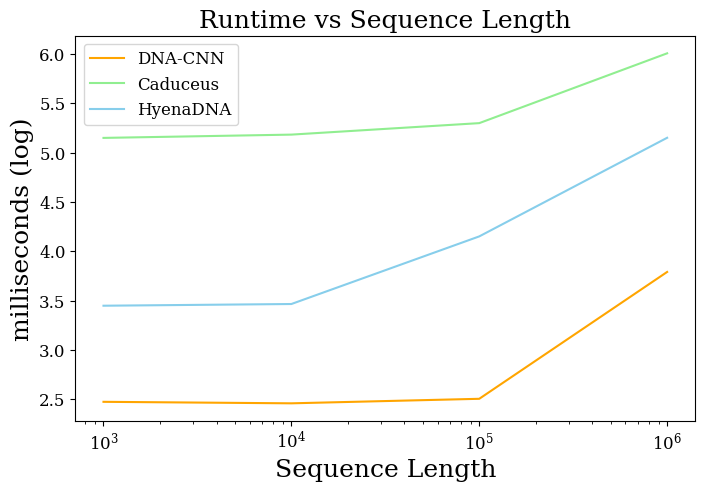

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x = np.array([10**3, 10**4, 10**5, 10**6])
y1 = np.array([2.4725839104371232, 2.4573111497102214, 2.5031975476036816, 3.7903673580863315])
y2 = np.array([5.150625995390467, 5.183961993183326, 5.300462119592287, 6.008886033431215])
y3 = np.array([3.447734595798473, 3.4649952047520824, 4.1511370766441374, 5.151766024356672])


plt.rc('font', family='serif', size=12)
plt.rc('axes', titlesize=16, labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=16)

# Create a new figure
plt.figure(num=3, figsize=(8, 5))

# Plot the first line with red color, solid line style, and circle markers
plt.plot(x, y1, label='DNA-CNN', linestyle='-', color='orange')

# Plot the second line with green color, dashed line style, and square markers
plt.plot(x, y2, label='Caduceus', linestyle='-', color='lightgreen')

# Plot the third line with blue color, dotted line style, and diamond markers
plt.plot(x, y3, label='HyenaDNA', linestyle='-', color='skyblue')

# Set labels for x and y axes
plt.xlabel('Sequence Length', fontsize=18)
plt.ylabel('milliseconds (log)', fontsize=18)

# Set log scale for x axis
plt.xscale('log')

# Set the title of the plot
plt.title('Runtime vs Sequence Length', fontsize=18)

# Manually set major tick locations on x-axis
plt.xticks([10**3, 10**4, 10**5, 10**6])

# Show grid lines
# plt.grid(False, which='both', linestyle='--', linewidth=0.5)
plt.grid(False)

# Show legend
plt.legend()
plt.savefig('runtime_vs_seqlen.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [5]:
5.15/3.79

1.3588390501319263